In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import sys
import os

%matplotlib inline

In [2]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [3]:
%ls

Clustering text data with k-means.ipynb
_96eadbec4d43a0b0870dde27d0652fb2_people_wiki_map_index_to_word.json.zip
_a20552cf806c54b71b3b87cb593b9968_kmeans-arrays.npz.zip
people_wiki_map_index_to_word.gl/
people_wiki_map_index_to_word.json
people_wiki_tf_idf.npz


In [7]:
wiki = pd.read_csv('people_wiki.csv')

In [9]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [10]:
map_index_to_word_tmp = pd.read_json('people_wiki_map_index_to_word.json', typ='series')
map_index_to_word = dict(zip(map_index_to_word_tmp.values, map_index_to_word_tmp.index))

## Normalize all vectors

In [29]:
tf_idf = normalize(tf_idf)

## Implement k-means

In [37]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None:
        np.random.seed(seed)
    n = data.shape[0] # number of data points
    
    # Pick K indices from range [0, N)
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will nonzero dues to averaging
    # As long as at least one document in a cluster contains a word
    # it will carry a nonzero weight in the TF-IDF vector of the centroid
    centroids = data[rand_indices, :].toarray()
    
    return centroids

In [39]:
tf_idf.shape

(59071, 547979)

In [38]:
queries = tf_idf[100:102, :]
dist = pairwise_distances(tf_idf, queries, metric='euclidean')
print (dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


In [ ]:
np.allclose

In [41]:
pairwise_distances(tf_idf[430,:], tf_idf[1,:])

array([[1.40713107]])

### Test your code

In [44]:
centroids = tf_idf[0:3, :]

In [45]:
dist = pairwise_distances(tf_idf, centroids)

In [47]:
dist

array([[0.        , 1.40775177, 1.38784582],
       [1.40775177, 0.        , 1.39867641],
       [1.38784582, 1.39867641, 0.        ],
       ...,
       [1.37070999, 1.40978937, 1.40616385],
       [1.35214578, 1.41306211, 1.40869799],
       [1.40799024, 1.41353429, 1.40903605]])

In [48]:
pairwise_distances(tf_idf[430,:], tf_idf[1, :])

array([[1.40713107]])

In [46]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Check your code again


In [53]:
dist.argmin(axis=1)

array([0, 1, 2, ..., 0, 0, 0])

In [54]:
closet_cluster = dist.argmin(axis=1)

In [57]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in dist]
if np.allclose(closet_cluster, reference):
    print ('Pass')
else:
    print ('Check your code again')

Pass


In [58]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignment = distances_from_centroids.argmin(axis=1)
    
    return cluster_assignment

#### Checkpoint

In [59]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Reviving clusters

In [60]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [61]:
cluster_assignment = assign_clusters(data, centroids)

In [62]:
cluster_assignment

array([0, 1, 0])

In [64]:
data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

In [75]:
A = data[cluster_assignment==0].mean(axis=0)

In [76]:
A

array([1.5, 2. , 0. ])

In [77]:
A = A.A1

AttributeError: 'numpy.ndarray' object has no attribute 'A1'

In [73]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        member_data_points = data[cluster_assignment == i]
        centroid = member_data_points.mean(axis=0)
        centroid = centroid.A1
        new_centroids.append(centroid)
    
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [74]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [79]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    
    for i in range(k):
        member_data_points = data[cluster_assignment==i, :]
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            distances = pairwise_distances(member_data_points, [centroids[i]],
                                          metric='euclidean')
            squared_distances = distances ** 2
            
            heterogeneity += np.sum(squared_distances)
            
    return heterogeneity

In [86]:
def kmeans(data, k, initial_centroids, maxiter,
           record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
    maxiter: maximum number of iterations to run.
    record_heterogeneity: (optional) a list to store the history of heterogeneity
    as function of iterations if None, do not store the history
    verbose: if True, print how many data points changed their cluster labels
    in each iteration
    '''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):
        if (verbose):
            print (itr)
        
        # 1. Make cluster assignments using nearest centroids
        cluster_assignment = assign_clusters(data, centroids)
        
        # 2. Compute a new centroid for each of the k clusters, averaging all
        # data points assigned to that cluster
        centroids = revise_centroids(data, k, cluster_assignment)
        
        # Check for convergence: if none of the assignment changed, stop
        if (prev_cluster_assignment is not None and  \
            (prev_cluster_assignment==cluster_assignment).all()):
            break
            
        # Print number of new assignments
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment != cluster_assignment)
            if verbose:
                print ('  {0:5d} elements changed their cluster assignment.'
                      .format(num_changed))
            
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
    
    return centroids, cluster_assignment

In [87]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
  19157 elements changed their cluster assignment.
2
   7739 elements changed their cluster assignment.
3
   5119 elements changed their cluster assignment.
4
   3370 elements changed their cluster assignment.
5
   2811 elements changed their cluster assignment.
6
   3233 elements changed their cluster assignment.
7
   3815 elements changed their cluster assignment.
8
   3172 elements changed their cluster assignment.
9
   1149 elements changed their cluster assignment.
10
    498 elements changed their cluster assignment.
11
    265 elements changed their cluster assignment.
12
    149 elements changed their cluster assignment.
13
    100 elements changed their cluster assignment.
14
     76 elements changed their cluster assignment.
15
     67 elements changed their cluster assignment.
16
     51 elements changed their cluster assignment.
17
     47 elements changed their cluster assignment.
18
     40 elements changed their cluster assignment.
19
     34 elements changed their c

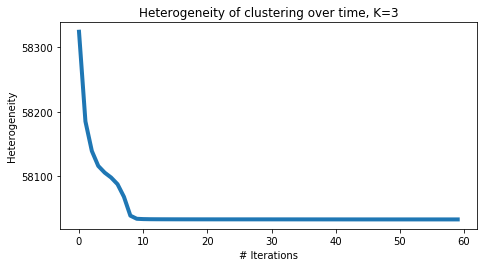

In [88]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

### Quiz Question. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.



TRUE

### Quiz Question. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

- k-means algorithm got stuck in a bad local minimum
- There is a bug in the k-means code
- All data points consist of exact duplicates
- Nothing is wrong. The objective should generally go down sooner or later.

There is a bug in the k-means code

### Quiz Question. Which of the cluster contains the greatest number of data points in the end? Hint: Use np.bincount() to count occurrences of each cluster label.

- Cluster #0
- Cluster #1
- Cluster #2

In [94]:
np.bincount(cluster_assignment).argmin() + 1

2

### Beaware of local minima

In [96]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    print('Cluster assignment: ', np.bincount(cluster_assignment))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
Cluster assignment:  [18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=020000, heterogeneity=57533.20100
Cluster assignment:  [ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=040000, heterogeneity=57512.69257
Cluster assignment:  [ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=060000, heterogeneity=57466.97925
Cluster assignment:  [ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=080000, heterogeneity=57494.92990
Cluster assignment:  [17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=100000, heterogeneity=57484.42210
Cluster assignment:  [ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=120000, heterogeneity=57554.62410
Cluster assignment:  [ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]
189.20208477973938


### Quiz Question. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?

In [101]:
np.min(np.array([[1,2,3, 8], [6,-4,2,8]]), axis=0)

array([ 1, -4,  2,  8])

In [103]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids
    '''
    if seed is not None:
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    
    squared_distances = pairwise_distances(data, centroids[0:1],
                                          metric='euclidean').flatten()**2
    
    for i in range(1, k):
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/
                               sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1],
                                                    metric='euclidean')**2, axis=1)
    
    return centroids

In [104]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heteogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    print('Cluster assignment: ', np.bincount(cluster_assignment))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heteogeneity=57468.63808
Cluster assignment:  [19618  3857  4173  5219  1743  6900  5530  1348  4384  6299]
seed=020000, heteogeneity=57486.94263
Cluster assignment:  [ 7132  1726  7419 20581  1941  5121  3777  3741   776  6857]
seed=040000, heteogeneity=57454.35926
Cluster assignment:  [17602  3415  3535  1736  6445  2552  7106  7155   599  8926]
seed=060000, heteogeneity=57530.43659
Cluster assignment:  [ 2655  9080  8047  2751 16942  1163  2810  6788  3389  5446]
seed=080000, heteogeneity=57454.51852
Cluster assignment:  [ 6222  2024  6461  6765  5538 18352  3936  1563  1751  6459]
seed=100000, heteogeneity=57471.56674
Cluster assignment:  [ 6459  5477  5746 17792  3436  1346  1743  3792  8075  5205]
seed=120000, heteogeneity=57523.28839
Cluster assignment:  [ 3791  5186  1349 16549  7119  2625  8441  1131  6223  6657]
223.4441339969635


In [109]:
list(heterogeneity.values())

[57457.52442292027,
 57533.20099687315,
 57512.692572562795,
 57466.97924645124,
 57494.92989694541,
 57484.42209612294,
 57554.624099931665]

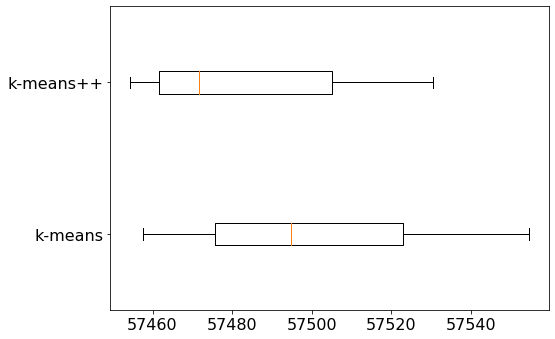

In [110]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [111]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

2
10
25
50
100


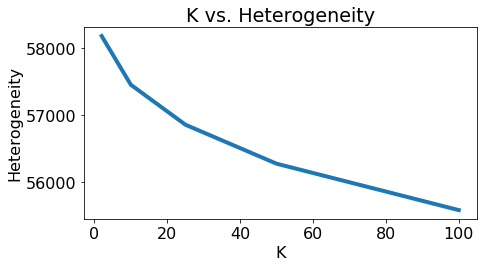

In [114]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print (k)
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [142]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            print (nearest_neighbors[0:8])
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                neighbor_id = nearest_neighbors[i]
                text = ' '.join(wiki.iloc[neighbor_id]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[neighbor_id]['name'],
                    distances[neighbor_id], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [145]:
k=10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0    
film:0.020
art:0.014
he:0.011
book:0.010
television:0.010

[37815   934 27250 32393 50025 36172 58179 50978]

* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                    

music:0.057
album:0.040
band:0.035
orchestra:0.023
released:0.022

[50957 27180 20496 13651 43208  8184  3517 10104]

* Brenton Broadstock                                 0.95722
  brenton broadstock ao born 1952 is an australian composerbroadstock was born in melbourne 
  he studied history politics and music at monash university and later composition

* Prince (musician)                                  0.96057
  prince rogers nelson born june 7 1958 known by his mononym prince is an american singerson
  gwriter multiinstrumentalist and actor he has produced ten platinum albums

* Will.i.am                                          0.96066
  william adams born march 15 1975 known by his stage name william pronounced will i am is a
  n american rapper songwriter entrepreneur actor dj record

* Tom Bancroft                                       0.96117
  tom bancroft born 1967 london is a british jazz drummer and composer he began drumming age
  d seven and started off playing jazz with

### Quiz question: Which of the 10 cluster above contains the greatest number of articles?

In [151]:
np.bincount(cluster_assignment[10])

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926])

In [150]:
np.bincount(cluster_assignment[10]).argmax()

0

### Quiz Question: Which of the 10 clusters above contains the least number of articles?

In [152]:
np.bincount(cluster_assignment[10]).argmin()

8

In [153]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
law:0.077
district:0.048
court:0.046
republican:0.038
senate:0.038

Cluster 1    
research:0.054
professor:0.033
science:0.032
university:0.031
physics:0.029

Cluster 2    
hockey:0.216
nhl:0.134
ice:0.065
season:0.052
league:0.047

Cluster 3    
party:0.065
election:0.042
elected:0.031
parliament:0.027
member:0.023

Cluster 4    
board:0.025
president:0.023
chairman:0.022
business:0.022
executive:0.020

Cluster 5    
minister:0.160
prime:0.056
cabinet:0.044
party:0.043
election:0.042

Cluster 6    
university:0.044
professor:0.037
studies:0.035
history:0.034
philosophy:0.031

Cluster 7    
election:0.066
manitoba:0.058
liberal:0.051
party:0.045
riding:0.043

Cluster 8    
racing:0.095
formula:0.056
championship:0.054
race:0.052
poker:0.051

Cluster 9    
economics:0.146
economic:0.096
economist:0.053
policy:0.048
research:0.043

Cluster 10    
championships:0.075
olympics:0.050
marathon:0.048
metres:0.048
she:0.048

Cluster 11    
she:0.144
her:0.092
miss:0.016
actress:0

In [154]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)

Cluster 0    
brazilian:0.137
brazil:0.082
de:0.056
rio:0.053
paulo:0.050

Cluster 1    
bishop:0.170
diocese:0.085
archbishop:0.083
church:0.072
ordained:0.058

Cluster 2    
zealand:0.247
new:0.069
auckland:0.056
wellington:0.031
zealands:0.029

Cluster 3    
comics:0.181
comic:0.121
strip:0.042
graphic:0.036
book:0.034

Cluster 4    
puerto:0.309
rico:0.220
rican:0.066
juan:0.041
ricos:0.031

Cluster 5    
bbc:0.192
radio:0.127
presenter:0.054
show:0.046
news:0.042

Cluster 6    
senate:0.059
district:0.053
county:0.051
committee:0.049
state:0.044

Cluster 7    
labor:0.105
australian:0.099
liberal:0.071
election:0.067
seat:0.061

Cluster 8    
economics:0.065
university:0.048
research:0.045
professor:0.043
economic:0.043

Cluster 9    
foreign:0.086
ambassador:0.076
affairs:0.061
nations:0.053
united:0.040

Cluster 10    
she:0.188
her:0.052
women:0.026
womens:0.020
council:0.019

Cluster 11    
rowing:0.246
sculls:0.097
rower:0.081
olympics:0.073
championships:0.068

Cluster 12   

de:0.127
la:0.059
el:0.035
mexico:0.026
y:0.025

Cluster 61    
jewish:0.193
rabbi:0.132
israel:0.052
hebrew:0.038
jews:0.032

Cluster 62    
ballet:0.362
dance:0.109
dancer:0.084
she:0.057
danced:0.044

Cluster 63    
hockey:0.220
nhl:0.138
ice:0.067
season:0.053
league:0.048

Cluster 64    
law:0.148
court:0.093
judge:0.071
district:0.051
justice:0.043

Cluster 65    
coach:0.205
head:0.086
basketball:0.059
coaching:0.052
football:0.046

Cluster 66    
armenian:0.278
armenia:0.168
yerevan:0.100
sargsyan:0.055
genocide:0.031

Cluster 67    
album:0.088
released:0.044
music:0.040
records:0.033
albums:0.027

Cluster 68    
she:0.158
her:0.152
music:0.020
album:0.016
singer:0.013

Cluster 69    
theatre:0.194
directed:0.034
production:0.031
play:0.029
actor:0.027

Cluster 70    
health:0.099
medical:0.089
medicine:0.086
research:0.039
clinical:0.039

Cluster 71    
european:0.145
parliament:0.115
party:0.053
member:0.049
committee:0.048

Cluster 72    
marathon:0.459
half:0.087
she:0.082

### Quiz Question. Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?



In [156]:
(np.bincount(cluster_assignment[100]) < 236).sum()

29